## Pipeline used for Aukland and Dublin

### Importing lib's

In [131]:
import os
import numpy as np
import pandas as pd
import holidays as hl
import time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sea

#Used with Pandas to help view hidden columns and rows  
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
OUTDIR = "data_weather/Final"
os.makedirs(OUTDIR, exist_ok=True)

import openmeteo_requests
import requests_cache
from retry_requests import retry

from statsmodels.tsa.stattools import adfuller

### Load in POI(Manually Created), Import Date Dataset(Generated with OpenAI ChatGPT5.2)

In [61]:
#POI Dataset
GB = pd.read_csv('data_weather/Global_Tourist_Attractions.csv') #Use for creating our time series data, POI and with lat and long
GB = GB[(GB['Country'] == 'Ireland') | (GB['Country'] == 'New Zealand')].reset_index(drop=True)
GB

,Location_Name,Type_of_Attraction,Attraction_Category,City,Country,Latitude,Longitude,Location_ID
0,Trinity College & Book of Kells,University,Cultural,Dublin,Ireland,53.3438,-6.2540,IRDUB_1
1,Guinness Storehouse,Historic Site,Cultural,Dublin,Ireland,53.3419,-6.2869,IRDUB_2
2,St Stephen's Green,Urban Park,Nature,Dublin,Ireland,53.3382,-6.2591,IRDUB_3
3,Temple Bar District,Entertainment District,Entertainment,Dublin,Ireland,53.3455,-6.2643,IRDUB_4
4,Dublin Castle,Historic Site,Cultural,Dublin,Ireland,53.3429,-6.2674,IRDUB_5
5,Phoenix Park,Urban Park,Nature,Dublin,Ireland,53.3560,-6.3290,IRDUB_6
6,St Patrick's Cathedral,Religious Site,Cultural,Dublin,Ireland,53.3395,-6.2710,IRDUB_7
7,EPIC The Irish Emigration Museum,Museum,Cultural,Dublin,Ireland,53.3471,-6.2416,IRDUB_8
8,Sky Tower,Observation Tower,Entertainment,Auckland,New Zealand,-36.8485,174.7633,NZAUK_1
9,Auckland War Memorial Museum,Museum,Cultural,Auckland,New Zealand,-36.8620,174.7769,NZAUK_2


### Load in Sensor Data sets

In [62]:
dfs_dub = [pd.read_csv(os.path.join('./data_weather/Dublin',f)) for f in os.listdir('./data_weather/Dublin') if f.endswith('.csv')] 
dfs_dub = [df.rename(columns={df.columns[0]:'Date'}) for df in dfs_dub] #Renaming Date column to Date  
for df in dfs_dub:
    df['Date'] = pd.to_datetime(df['Date'],format='mixed',utc=True,dayfirst=True).dt.strftime('%Y-%m-%d %H:%M:%S')#Data set contains mixed formats, must use day first for y/m/d
    df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d %H:%M:%S')#Want to make sure that date is in datetime not object
    
dfs_auk = [pd.read_csv(os.path.join('./data_weather/Auckland Data',f)) for f in os.listdir('./data_weather/Auckland Data') if f.endswith('.csv')] 
Temp = []
for df in dfs_auk:
    df['Date'] = df['Date'].astype(str) + ' ' + df['Time'].astype(str).str.split('-',expand=True)[0]
    df['Date'] = pd.to_datetime(df['Date'],format='mixed',utc=True).dt.strftime('%Y-%m-%d %H:%M:%S')
    df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d %H:%M:%S')
    df = df.drop(columns=['Time']) #Dataset contains a time column, droped it, already combined with dates 
    if df['150 K Road'].dtypes == object: #Theres a '-' in column '150  K Road' of one of the data sets 
                                                                #coerce invalid parsing --> NaN then --> 0.0 
        df['150 K Road'] = df['150 K Road'].apply(lambda x: 0.0 if type(x) != int and type(x) != float else x) 
    Temp.append(df)
dfs_auk = Temp

In [63]:
for df in dfs_dub:
    display(df.loc[3239:3240])
    break
print('-')
for df in dfs_auk:
    display(df.loc[3239:3240])
    break

,Date,Aston Quay/Fitzgeralds,Aston Quay/Fitzgeralds IN,Aston Quay/Fitzgeralds OUT,Bachelors walk/Bachelors way,Bachelors walk/Bachelors way IN,Bachelors walk/Bachelors way OUT,Baggot st lower/Wilton tce inbound,Baggot st lower/Wilton tce inbound Pedestrians IN,Baggot st lower/Wilton tce inbound Pedestrians OUT,Baggot st upper/Mespil rd/Bank,Baggot st upper/Mespil rd/Bank Pedestrians IN,Baggot st upper/Mespil rd/Bank Pedestrians OUT,Capel st/Mary street,Capel st/Mary street Pedestrian IN,Capel st/Mary street Pedestrian OUT,College Green/Bank Of Ireland,College Green/Bank Of Ireland IN,College Green/Bank Of Ireland OUT,College Green/Church Lane,College Green/Church Lane IN,College Green/Church Lane OUT,College st/Westmoreland st,College st/Westmoreland st IN,College st/Westmoreland st OUT,D'olier st/Burgh Quay,D'olier st/Burgh Quay IN,D'olier st/Burgh Quay OUT,Dame Street/Londis,Dame Street/Londis Pedestrian IN,Dame Street/Londis Pedestrian OUT,Dawson Street/Molesworth,Dawson Street/Molesworth IN,Dawson Street/Molesworth OUT,Grafton st/Monsoon,Grafton st/Monsoon Pedestrian IN,Grafton st/Monsoon Pedestrian OUT,Grafton Street / Nassau Street / Suffolk Street,Grafton Street / Nassau Street / Suffolk Street IN,Grafton Street / Nassau Street / Suffolk Street OUT,Grafton Street/CompuB,Grafton Street/CompuB IN,Grafton Street/CompuB OUT,Grand Canal st upp/Clanwilliam place,Grand Canal st upp/Clanwilliam place Pedestrians IN,Grand Canal st upp/Clanwilliam place Pedestrians OUT,Grand Canal st upp/Clanwilliam place/Google,Grand Canal st upp/Clanwilliam place/Google Pedestrians IN,Grand Canal st upp/Clanwilliam place/Google Pedestrians OUT,Henry Street/Coles Lane/Dunnes,Henry Street/Coles Lane/Dunnes Pedestrian IN,Henry Street/Coles Lane/Dunnes Pedestrian OUT,Liffey st/Halfpenny Bridge,Liffey st/Halfpenny Bridge IN,Liffey st/Halfpenny Bridge OUT,Mary st/Jervis st,Mary st/Jervis st IN,Mary st/Jervis st OUT,Newcomen Bridge/Charleville mall inbound,Newcomen Bridge/Charleville mall inbound Pedestrians IN,Newcomen Bridge/Charleville mall inbound Pedestrians OUT,Newcomen Bridge/Charleville mall outbound,Newcomen Bridge/Charleville mall outbound Pedestrians IN,Newcomen Bridge/Charleville mall outbound Pedestrians OUT,North Wall Quay/Samuel Beckett bridge East,North Wall Quay/Samuel Beckett bridge East Channel 1 IN,North Wall Quay/Samuel Beckett bridge East Channel 2 OUT,North Wall Quay/Samuel Beckett bridge West,North Wall Quay/Samuel Beckett bridge West Pedestrians IN,North Wall Quay/Samuel Beckett bridge West Pedestrians OUT,O'Connell St/Parnell St/AIB,O'Connell St/Parnell St/AIB IN,O'Connell St/Parnell St/AIB OUT,O'Connell St/Pennys Pedestrian,O'Connell St/Pennys IN,O'Connell St/Pennys OUT,O'Connell st/Princes st North,O'Connell st/Princes st North IN,O'Connell st/Princes st North OUT,Phibsborough Rd/Enniskerry Road,Phibsborough Rd/Enniskerry Road Pedestrians IN,Phibsborough Rd/Enniskerry Road Pedestrians OUT,Phibsborough Rd/Munster St,Phibsborough Rd/Munster St Peds IN,Phibsborough Rd/Munster St Peds OUT,Richmond st south/Portabello Harbour inbound,Richmond st south/Portabello Harbour inbound Pedestrians IN,Richmond st south/Portabello Harbour inbound Pedestrians OUT,Richmond st south/Portabello Harbour outbound,Richmond st south/Portabello Harbour outbound Pedestrians IN,Richmond st south/Portabello Harbour outbound Pedestrians OUT,Talbot st/Guineys,Talbot st/Guineys IN,Talbot st/Guineys OUT,Talbot st/Murrays Pharmacy,Talbot st/Murrays Pharmacy IN,Talbot st/Murrays Pharmacy OUT,Westmoreland Street East/Fleet street,Westmoreland Street East/Fleet street IN,Westmoreland Street East/Fleet street OUT,Westmoreland Street West/Carrolls,Westmoreland Street West/Carrolls IN,Westmoreland Street West/Carrolls OUT
3239,2021-05-15 23:00:00,NaN,NaN,NaN,215.0,133.0,82.0,12.0,10.0,2.0,39.0,17.0,22.0,NaN,NaN,NaN,268.0,189.0,79.0,199.0,90.0,109.0,60.0,26.0,34.0,451.0,194.0,257.0,NaN,NaN,NaN,16.0,9.0,7.0,346.0,158.0,188.0,40.0,18.0,22.0,157.0,113.0,44.0,50.0,1

-


,Date,107 Quay Street,Te Ara Tahuhu Walkway,Commerce Street West,7 Custom Street East,45 Queen Street,30 Queen Street,19 Shortland Street,2 High Street,1 Courthouse Lane,61 Federal Street,59 High Street,210 Queen Street,205 Queen Street,8 Darby Street EW,8 Darby Street NS,261 Queen Street,297 Queen Street,150 K Road,183 K Road
3239,2021-05-15 05:00:00,0,41,2,27,26,69,5,26,5,15,17,67,20,6,5,39,41,21,87
3240,2021-05-16 06:00:00,0,22,13,44,45,68,8,11,8,16,22,47,9,12,18,56,37,20,42


### Help with shrinking down columns for each vstack dataset to allow better column trageting

In [64]:
#They exist in all datasets for Dublin (From Dublin gov data website) 
Dublin_latlong = {
    "Henry Street/Coles Lane/Dunnes":[53.34973,-6.2609],
    "O'Connell st/Princes st North":[53.34902,-6.26005],
    "Mary st/Jervis st":[53.34877,-6.26674],
    "Capel st/Mary street":[53.34842,-6.26918],
    "Aston Quay/Fitzgeralds":[53.34662,-6.25982],
    "Grafton Street/CompuB":[53.34337,-6.25898],
    "Talbot st/Guineys":[53.35054,-6.25528],
    "D'olier st/Burgh Quay":[53.3469,-6.25872],
    "Dame Street/Londis":[53.34424,-6.26116],
    "Talbot st/Murrays Pharmacy":[53.35012,-6.2577],
    "O'Connell St/Parnell St/AIB":[53.35231721,-6.261675274],
    "Grafton Street / Nassau Street / Suffolk Street":[53.34352,-6.25912],
    "College Green/Bank Of Ireland":[53.34505,-6.25939],
    "O'Connell St/Pennys Pedestrian":[53.34874,-6.26011],
    "Grafton st/Monsoon":[53.34082,-6.26035],
    "Westmoreland Street East/Fleet street":[53.34554,-6.25919],
    "Dawson Street/Molesworth Pedestrian":[53.341194,-6.258337],
    "Liffey st/Halfpenny Bridge":[53.34687,-6.26335],
    "Westmoreland Street West/Carrolls":[53.34634753,-6.259197438],
    "College Green/Church Lane":[53.3442633,-6.260774367],
    "College st/Westmoreland st":[53.34509951,-6.258778243],
    "Bachelors walk/Bachelors way":[53.34719979,-6.260863323],
    "Baggot st lower/Wilton tce inbound":[53.33448,-6.24577],
    "Baggot st upper/Mespil rd/Bank":[53.33385,-6.24469],
    "Grand Canal st upp/Clanwilliam place":[53.33851,-6.2379],
    "Grand Canal st upp/Clanwilliam place/Google":[53.33851,-6.239],
    "Newcomen Bridge/Charleville mall inbound":[53.35645,-6.24418],
    "Newcomen Bridge/Charleville mall outbound":[53.35648,-6.24418],
    "North Wall Quay/Samuel Beckett bridge East":[53.346,-6.24173],
    "North Wall Quay/Samuel Beckett bridge West":[53.34748,-6.24132],
    "Phibsborough Rd/Enniskerry Road":[53.36334,-6.27187],
    "Phibsborough Rd/Munster St (Removed due to Overcounting)":[53.36322,-6.27247],
    "Richmond st south/Portabello Harbour inbound":[53.33034,-6.26427],
    "Richmond st south/Portabello Harbour outbound":[53.33023,-6.26397],
}

#They exist in all datasets for Auckland (From Auckland gov data website) 
Auckland_latlong= {
    "107 Quay Street":[-36.843015,174.766494],
    "188 Quay Street Lower Albert (EW)":[-36.84306,174.76573],
    "188 Quay Street Lower Albert (NS)":[-36.84306,174.76573],
    "Te Ara Tahuhu Walkway":[-36.84465,174.769645],
    "Commerce Street West":[-36.844912,174.768065],
    "7 Custom Street East":[-36.844722,174.767057],
    "45 Queen Street":[-36.845001,174.766266],
    "30 Queen Street":[-36.84495,174.766575],
    "19 Shortland Street":[-36.846576,174.766946],
    "2 High Street":[-36.846846,174.766855],
    "1 Courthouse Lane":[-36.84817,174.76705],
    "61 Federal Street":[-36.847964,174.762729],
    "59 High Stret":[-36.848924,174.766186],
    "210 Queen Street":[-36.848899,174.76541],
    "205 Queen Street":[-36.848986,174.764784],
    "8 Darby Street EW":[-36.849422,174.764172],
    "8 Darby Street NS":[-36.849422,174.764172],
    "261 Queen Street":[-36.850792,174.764556],
    "297 Queen Street":[-36.852232,174.763915],
    "150 K Road":[-36.857973,174.760382],
    "183 K Road":[-36.857774,174.760123],
}

### V Stacker used to combine data set on top of each other per city

In [65]:
def combiner(DSArray:list[pd.DataFrame],colToKp:list,startdate)->pd.DataFrame:
    #Stack each dataset on top of each other
    vstk = pd.concat(DSArray) 
    #Take the column names that don't exist in colToKp that don't exist in all other orginal datasets, keep date
    drpcols = [cn for cn in vstk.columns if cn not in colToKp and cn != 'Date']
    #Drop columns that we do not need
    vstk = vstk.drop(columns=drpcols).reset_index(drop=True)
    vstk = vstk.sort_values(by='Date',ascending=True)
    #Trimming beginning of dataset
    vstk = vstk[vstk['Date'] >= startdate] 
    return vstk

In [66]:
vDub = combiner(dfs_dub,list(Dublin_latlong.keys()),'2021-01-01 00:00:00') #Obtain processed v stacked 
display(vDub.head(2))
print(vDub['Date'].dtype)

,Date,Aston Quay/Fitzgeralds,Bachelors walk/Bachelors way,Baggot st lower/Wilton tce inbound,Baggot st upper/Mespil rd/Bank,Capel st/Mary street,College Green/Bank Of Ireland,College Green/Church Lane,College st/Westmoreland st,D'olier st/Burgh Quay,Dame Street/Londis,Grafton st/Monsoon,Grafton Street / Nassau Street / Suffolk Street,Grafton Street/CompuB,Grand Canal st upp/Clanwilliam place,Grand Canal st upp/Clanwilliam place/Google,Henry Street/Coles Lane/Dunnes,Liffey st/Halfpenny Bridge,Mary st/Jervis st,Newcomen Bridge/Charleville mall inbound,Newcomen Bridge/Charleville mall outbound,North Wall Quay/Samuel Beckett bridge East,North Wall Quay/Samuel Beckett bridge West,O'Connell St/Parnell St/AIB,O'Connell St/Pennys Pedestrian,O'Connell st/Princes st North,Phibsborough Rd/Enniskerry Road,Richmond st south/Portabello Harbour inbound,Richmond st south/Portabello Harbour outbound,Talbot st/Guineys,Talbot st/Murrays Pharmacy,Westmoreland Street East/Fleet street,Westmoreland Street West/Carrolls,Dawson Street/Molesworth Pedestrian,Phibsborough Rd/Munster St (Removed due to Overcounting)
0,2021-01-01 00:00:00,165.0,66.0,5.0,13.0,NaN,163.0,52.0,27.0,793.0,NaN,94.0,9.0,111.0,17.0,1.0,227.0,43.0,NaN,14.0,9.0,2060.0,52.0,85.0,137.0,125.0,164.0,34.0,18.0,375.0,525.0,33.0,220.0,NaN,NaN
1,2021-01-01 01:00:00,25.0,18.0,1.0,4.0,NaN,66.0,12.0,18.0,448.0,NaN,26.0,2.0,42.0,7.0,5.0,64.0,28.0,NaN,17.0,7.0,1127.0,91.0,29.0,53.0,51.0,402.0,7.0,15.0,137.0,1204.0,22.0,112.0,NaN,NaN


datetime64[ns]


In [67]:
vAuk = combiner(dfs_auk,list(Auckland_latlong.keys()),'2021-01-01 06:00:00') #Obtain processed v stacked 
display(vAuk.head(2))
print(vAuk['Date'].dtype)

,Date,107 Quay Street,Te Ara Tahuhu Walkway,Commerce Street West,7 Custom Street East,45 Queen Street,30 Queen Street,19 Shortland Street,2 High Street,1 Courthouse Lane,61 Federal Street,210 Queen Street,205 Queen Street,8 Darby Street EW,8 Darby Street NS,261 Queen Street,297 Queen Street,150 K Road,183 K Road,188 Quay Street Lower Albert (EW),188 Quay Street Lower Albert (NS),59 High Stret
0,2021-01-01 06:00:00,0.0,17.0,53.0,67.0,100.0,188.0,7.0,15.0,12.0,35.0,151.0,63.0,19.0,21.0,89.0,93.0,31.0,72.0,NaN,NaN,NaN
1,2021-01-01 07:00:00,0.0,70.0,34.0,52.0,87.0,140.0,15.0,19.0,13.0,45.0,77.0,45.0,20.0,25.0,72.0,60.0,15.0,63.0,NaN,NaN,NaN


datetime64[ns]


### Adding the missing dates and then applying mean to fill in the missing values after removing columns with too many NaN's with Threshold

In [68]:
#Drop duplicates of the dates then return data frame with missing date rows filled in using mean for sensor data
def Re_indxing(vData:pd.DataFrame)->pd.DataFrame:
    df = vData.copy()
    df = df.drop_duplicates(subset='Date', keep='first')
    df = df.set_index('Date')
    msg = df.isna().mean().sort_values(ascending=False) # determine the amount of nan in a column and get mean
    for vl,cn in zip(msg.values,msg.index):
        if vl < 0.01:
            df[cn] = df[cn].interpolate(method='time',limit=24,limit_direction="both")
        if vl >= 0.01 and vl <= 0.15:
            df[cn] = df[cn].interpolate(method='time',limit=24,limit_direction="both")
            df[cn] = df[cn].ffill().bfill()
    msg = df.isna().mean().sort_values(ascending=False)
    df = df.drop(columns=[cn for vl,cn in zip(msg.values,msg.index) if vl > 0],axis=1)
    df = df.reset_index(drop=False)
    return df

In [69]:
vDub_re_indx = Re_indxing(vDub)
display(vDub_re_indx.head(2))
display(vDub_re_indx.isna().sum())

,Date,Baggot st upper/Mespil rd/Bank,Capel st/Mary street,College Green/Bank Of Ireland,College Green/Church Lane,College st/Westmoreland st,D'olier st/Burgh Quay,Grafton Street / Nassau Street / Suffolk Street,Grafton Street/CompuB,Grand Canal st upp/Clanwilliam place,Grand Canal st upp/Clanwilliam place/Google,Henry Street/Coles Lane/Dunnes,Mary st/Jervis st,North Wall Quay/Samuel Beckett bridge West,O'Connell St/Parnell St/AIB,Phibsborough Rd/Enniskerry Road,Richmond st south/Portabello Harbour inbound,Richmond st south/Portabello Harbour outbound
0,2021-01-01 00:00:00,13.0,0.0,163.0,52.0,27.0,793.0,9.0,111.0,17.0,1.0,227.0,0.0,52.0,85.0,164.0,34.0,18.0
1,2021-01-01 01:00:00,4.0,0.0,66.0,12.0,18.0,448.0,2.0,42.0,7.0,5.0,64.0,0.0,91.0,29.0,402.0,7.0,15.0


Date                                               0
Baggot st upper/Mespil rd/Bank                     0
Capel st/Mary street                               0
College Green/Bank Of Ireland                      0
College Green/Church Lane                          0
College st/Westmoreland st                         0
D'olier st/Burgh Quay                              0
Grafton Street / Nassau Street / Suffolk Street    0
Grafton Street/CompuB                              0
Grand Canal st upp/Clanwilliam place               0
Grand Canal st upp/Clanwilliam place/Google        0
Henry Street/Coles Lane/Dunnes                     0
Mary st/Jervis st                                  0
North Wall Quay/Samuel Beckett bridge West         0
O'Connell St/Parnell St/AIB                        0
Phibsborough Rd/Enniskerry Road                    0
Richmond st south/Portabello Harbour inbound       0
Richmond st south/Portabello Harbour outbound      0
dtype: int64

In [71]:
vAuk_re_indx = Re_indxing(vAuk)
display(vAuk_re_indx.head(2))
display(vAuk_re_indx.isna().sum())

,Date,107 Quay Street,Te Ara Tahuhu Walkway,Commerce Street West,7 Custom Street East,45 Queen Street,30 Queen Street,19 Shortland Street,2 High Street,1 Courthouse Lane,61 Federal Street,210 Queen Street,205 Queen Street,8 Darby Street EW,8 Darby Street NS,261 Queen Street,297 Queen Street,150 K Road,183 K Road
0,2021-01-01 06:00:00,0.0,17.0,53.0,67.0,100.0,188.0,7.0,15.0,12.0,35.0,151.0,63.0,19.0,21.0,89.0,93.0,31.0,72.0
1,2021-01-01 07:00:00,0.0,70.0,34.0,52.0,87.0,140.0,15.0,19.0,13.0,45.0,77.0,45.0,20.0,25.0,72.0,60.0,15.0,63.0


Date                     0
107 Quay Street          0
Te Ara Tahuhu Walkway    0
Commerce Street West     0
7 Custom Street East     0
45 Queen Street          0
30 Queen Street          0
19 Shortland Street      0
2 High Street            0
1 Courthouse Lane        0
61 Federal Street        0
210 Queen Street         0
205 Queen Street         0
8 Darby Street EW        0
8 Darby Street NS        0
261 Queen Street         0
297 Queen Street         0
150 K Road               0
183 K Road               0
dtype: int64

### Column Targeting, target columns who are close to POI and store them for later in a list

In [72]:
def Targeting(latlong:dict,tol:float,Country:str)->list[pd.Series,list[str]]:    
    trg_cols = []
    for i,r in GB[GB['Country']==Country].reset_index(drop=True).iterrows():#Grab the row with correct country
        #Finding Intersections which are close to POI Lat and Long (taking a tol into consideration) 
        Lat,Long = r['Latitude'],r['Longitude']
        cols_targeted = [key for key, value in latlong.items() if (value[0] - Lat) <= tol and (value[1] - Long) <= tol] 
        #Find no intersect that are close than go to next POI
        if not cols_targeted:continue 
        cols_targeted.insert(0,'Date')
        trg_cols.append([r,cols_targeted])
    return trg_cols

In [73]:
#filter out the sensors that were taken out in the processed v stack
flt_Dublin_latlong = {key: value for key, value in Dublin_latlong.items() if key in vDub_re_indx.columns[1:].to_list()}
dubTrg = Targeting(flt_Dublin_latlong,0.0059,'Ireland')#0.02514 #0.00491 # 0.00313
print(*[[r[1]]  for r in dubTrg],sep='\n')

[['Date', 'Mary st/Jervis st', 'Capel st/Mary street', 'Grafton Street/CompuB', "D'olier st/Burgh Quay", 'Grafton Street / Nassau Street / Suffolk Street', 'College Green/Bank Of Ireland', 'College Green/Church Lane', 'College st/Westmoreland st', 'Richmond st south/Portabello Harbour inbound', 'Richmond st south/Portabello Harbour outbound']]
[['Date', 'Grafton Street/CompuB', 'Grafton Street / Nassau Street / Suffolk Street', 'Richmond st south/Portabello Harbour inbound', 'Richmond st south/Portabello Harbour outbound']]
[['Date', 'Henry Street/Coles Lane/Dunnes', 'Mary st/Jervis st', 'Capel st/Mary street', 'Grafton Street/CompuB', "D'olier st/Burgh Quay", 'Grafton Street / Nassau Street / Suffolk Street', 'College Green/Bank Of Ireland', 'College Green/Church Lane', 'College st/Westmoreland st', 'Richmond st south/Portabello Harbour inbound', 'Richmond st south/Portabello Harbour outbound']]
[['Date', 'Mary st/Jervis st', 'Capel st/Mary street', 'Richmond st south/Portabello Harbo

In [74]:
#filter out the sensors that were taken out in the processed v stack
flt_Auckland_latlong = {key: value for key, value in Auckland_latlong.items() if key in vAuk_re_indx.columns[1:]}
aukTrg = Targeting(flt_Auckland_latlong,0.00222,'New Zealand')#0.00132299 # 0.002222
print(*[[r[1]] for r in aukTrg],sep='\n')

[['Date', '61 Federal Street', '210 Queen Street', '205 Queen Street', '8 Darby Street EW', '8 Darby Street NS', '261 Queen Street', '297 Queen Street', '150 K Road', '183 K Road']]
[['Date', '107 Quay Street', 'Commerce Street West', '7 Custom Street East', '45 Queen Street', '30 Queen Street', '19 Shortland Street', '2 High Street', '1 Courthouse Lane', '61 Federal Street', '210 Queen Street', '205 Queen Street', '8 Darby Street EW', '8 Darby Street NS', '261 Queen Street', '297 Queen Street', '150 K Road', '183 K Road']]
[['Date', '19 Shortland Street', '2 High Street', '1 Courthouse Lane', '61 Federal Street', '210 Queen Street', '205 Queen Street', '8 Darby Street EW', '8 Darby Street NS', '261 Queen Street', '297 Queen Street', '150 K Road', '183 K Road']]
[['Date', '297 Queen Street', '150 K Road', '183 K Road']]


### Grab the target columns and create a new data frame with poi's final transformed in hrly

In [75]:
def Forger(vdf:pd.DataFrame,trgcols:list) -> pd.DataFrame: 
    finalFrm = pd.DataFrame() #The final data frame that will house all poi's final transformed data in hrly

    for poi in trgcols:
        cols = vdf[poi[1]].replace(np.NaN,0.0) #Houses all of the cols pedestrian data related to a poi, if sensor doesn't count for an hour turn to 0 countm don't assume crowd number

        #Combine sesnor data of traget columns with sum for pedestrain counts, row wise
        m = pd.DataFrame(columns=['Date','PedsSen_Count'])
        m['Date'] = cols['Date']
        m['PedsSen_Count'] = cols.loc[:, cols.columns[1:]].sum(axis=1).to_frame()

        #Insert the meta data for the poi 
        m.insert(0,'Longitude',poi[0][['Longitude']].iloc[0])
        m.insert(0,'Latitude',poi[0][['Latitude']].iloc[0])
        m.insert(0,'Attraction_Category',poi[0][['Attraction_Category']].iloc[0])
        m.insert(0,'Type_of_Attraction',poi[0][['Type_of_Attraction']].iloc[0])
        m.insert(0,'Location_Name',poi[0][['Location_Name']].iloc[0])
        m.insert(0,'Location_ID',poi[0][['Location_ID']].iloc[0])
        m.insert(0,'City',poi[0][['City']].iloc[0])
        m.insert(0,'Country',poi[0][['Country']].iloc[0])
        
        #Concat bottom of poi final transformed data frame
        finalFrm = pd.concat([finalFrm,m],axis='index')
        
    return finalFrm

In [76]:
fDub = Forger(vDub_re_indx,dubTrg)

In [78]:
fAuk = Forger(vAuk_re_indx,aukTrg)

### Convert the data from hourly to daily interval

In [109]:
def hr_to_d(data:pd.DataFrame)->pd.DataFrame:
    data_hr = data.copy()
    data_hr["Date"] = pd.to_datetime(data_hr["Date"])

    #Automatically keep all columns BEFORE pedestrian column and remove Date column
    peds_idx = list(data_hr.columns).index('PedsSen_Count')
    meta_cols_before_peds = list(data_hr.columns[:peds_idx])
    meta_cols_before_peds.remove('Date')
    META_RULE = {cn:'first' for cn in meta_cols_before_peds}

    #Process per Location_ID
    out = []

    for loc, sub in data_hr.groupby("Location_ID", sort=False):
        # Set index on Date to help with resampling processes
        sub = sub.sort_values("Date").set_index("Date")

        # Anchor bins to the first timestamp in this Location_ID
        anchor = sub.index.min()

        # Resample columns
        BeforeDate = sub.resample("D",origin=anchor, label="left", closed="left").agg(META_RULE)
        Peds_d = sub["PedsSen_Count"].resample("D", origin=anchor, label="left", closed="left").sum()
        
        # Combine the Resamples
        daily = BeforeDate.join(Peds_d, how="inner").reset_index()

        out.append(daily)

    #Restack the locations on top of each other to re build the data set
    data_d = pd.concat(out, ignore_index=True) #<-- issue with auckland sometimes injects none row
    data_d = data_d[data_d['Location_ID'].notna()] #<---drops rows where column value is None
    data_d = data_d.reindex(columns=data.columns)
    
    data_d["Date"] = pd.to_datetime(data_d["Date"]).dt.floor('D')
    
    return data_d

In [110]:
fDub_d = hr_to_d(fDub)

In [111]:
fAuk_d = hr_to_d(fAuk)

### Visualizing the 3hr data before adding additional features 

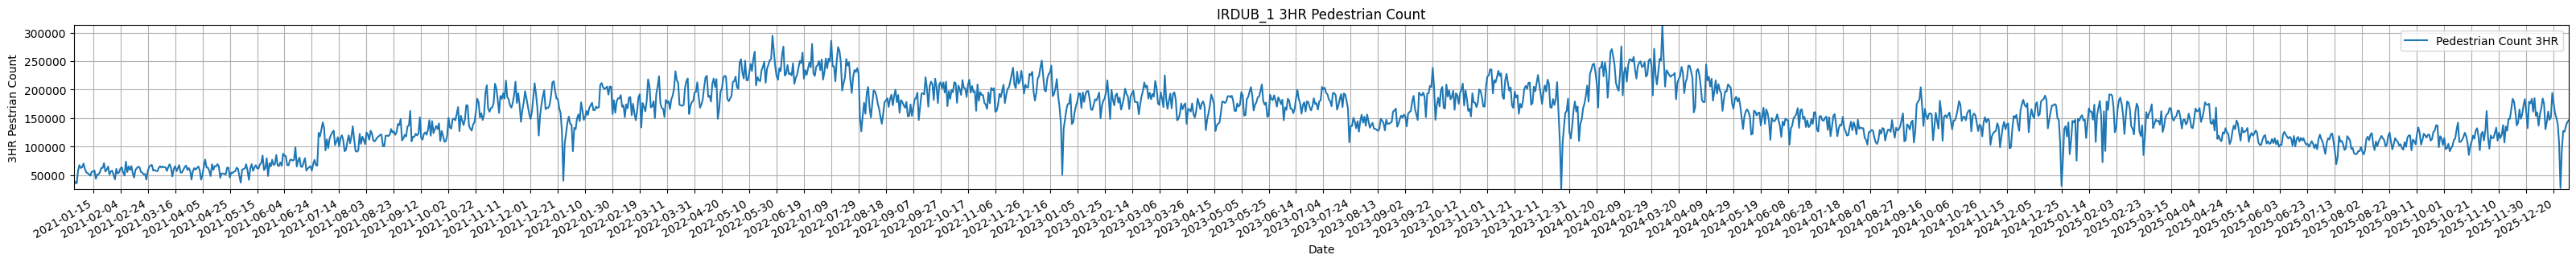

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count
0,Ireland,Dublin,IRDUB_1,Trinity College & Book of Kells,University,Cultural,53.3438,-6.254,2021-01-01,33648.0
1,Ireland,Dublin,IRDUB_1,Trinity College & Book of Kells,University,Cultural,53.3438,-6.254,2021-01-02,38277.0


Not Stationary


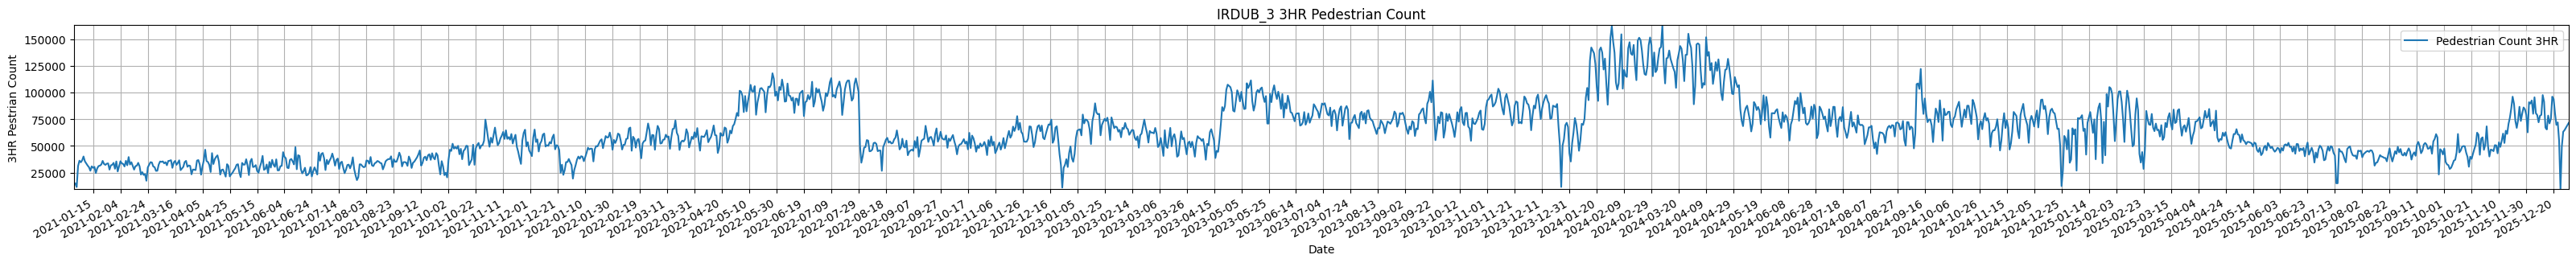

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count
1826,Ireland,Dublin,IRDUB_3,St Stephen's Green,Urban Park,Nature,53.3382,-6.2591,2021-01-01,12914.0
1827,Ireland,Dublin,IRDUB_3,St Stephen's Green,Urban Park,Nature,53.3382,-6.2591,2021-01-02,14915.0


Stationary


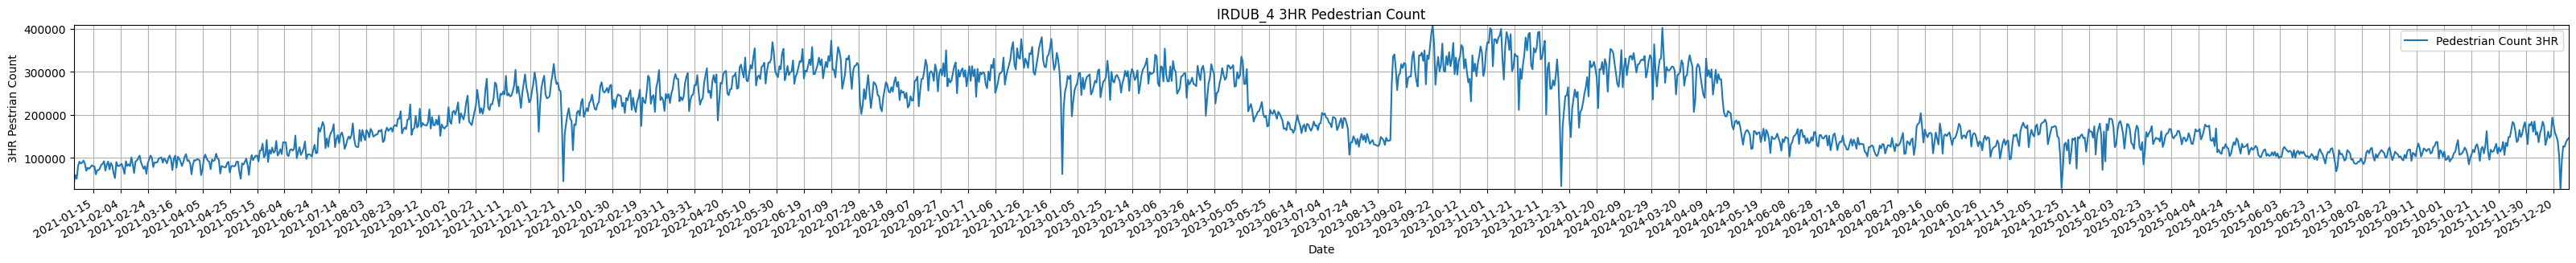

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count
3652,Ireland,Dublin,IRDUB_4,Temple Bar District,Entertainment District,Entertainment,53.3455,-6.2643,2021-01-01,43501.0
3653,Ireland,Dublin,IRDUB_4,Temple Bar District,Entertainment District,Entertainment,53.3455,-6.2643,2021-01-02,60374.0


Not Stationary


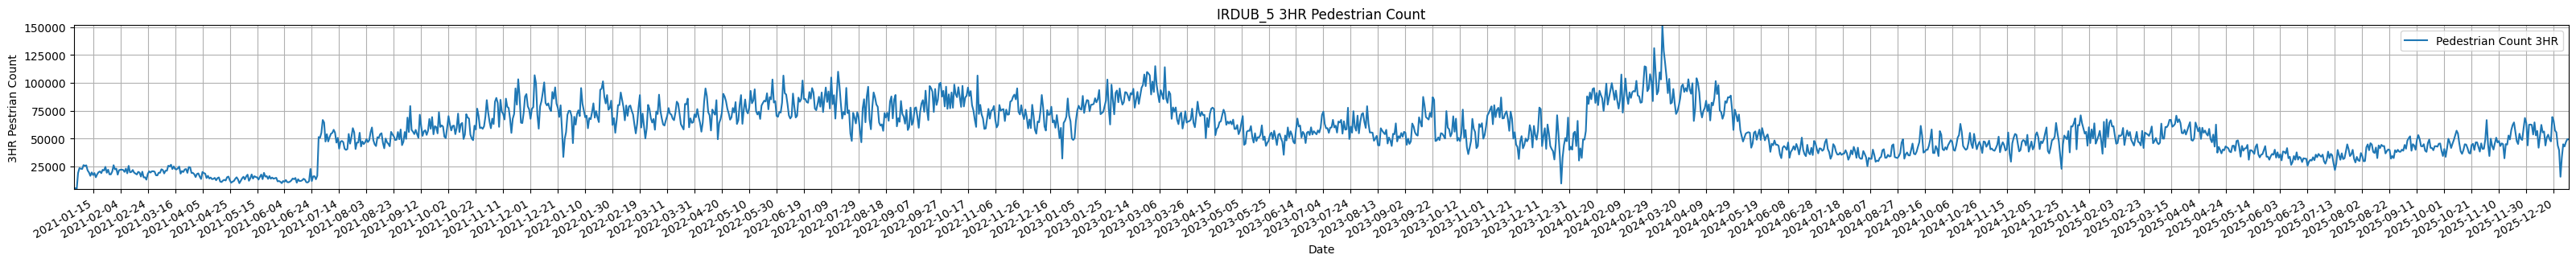

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count
5478,Ireland,Dublin,IRDUB_5,Dublin Castle,Historic Site,Cultural,53.3429,-6.2674,2021-01-01,4843.0
5479,Ireland,Dublin,IRDUB_5,Dublin Castle,Historic Site,Cultural,53.3429,-6.2674,2021-01-02,5331.0


Not Stationary


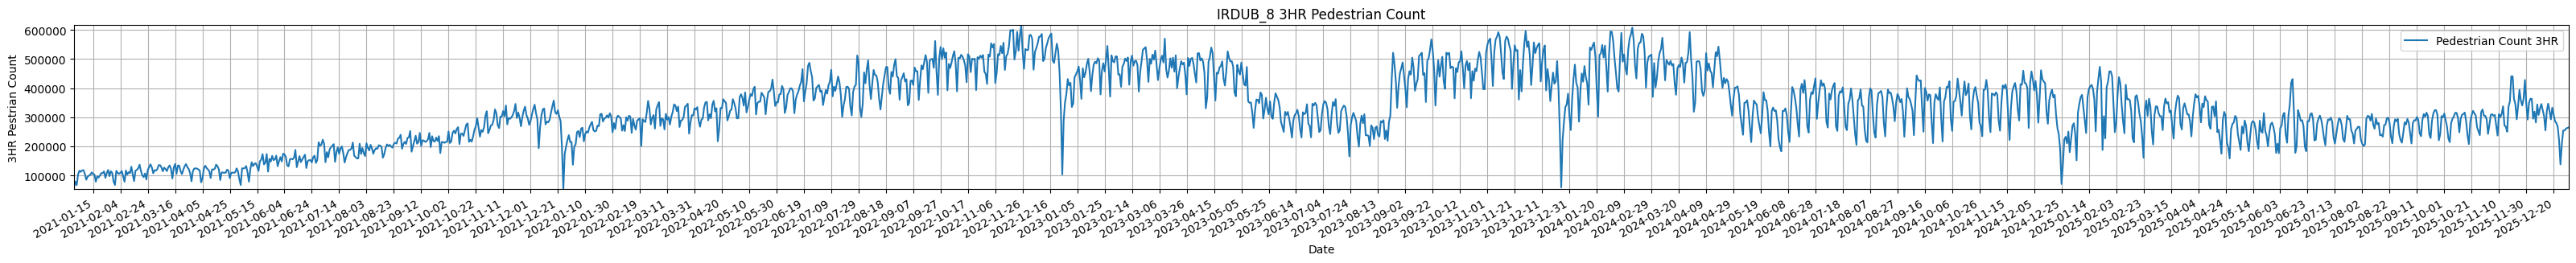

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count
7304,Ireland,Dublin,IRDUB_8,EPIC The Irish Emigration Museum,Museum,Cultural,53.3471,-6.2416,2021-01-01,58105.0
7305,Ireland,Dublin,IRDUB_8,EPIC The Irish Emigration Museum,Museum,Cultural,53.3471,-6.2416,2021-01-02,78957.0


Not Stationary


In [112]:
for loc in fDub_d['Location_ID'].unique():
    sub = fDub_d[fDub_d['Location_ID'] == loc].sort_values('Date')
    fig,ax = plt.subplots(figsize=(40,3))
    plt.margins(x=0,y=0)
    ax.set_xlabel('Date')
    ax.set_ylabel(f'3HR Pestrian Count')
    ax.plot(sub['Date'], sub['PedsSen_Count'], label='Pedestrian Count 3HR')
    ax.grid(True)
    ax.legend()
    ax.set_title(f'{loc} 3HR Pedestrian Count')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=20))
    fig.autofmt_xdate() # Prevent overcrowding on the x-axis for label 
    plt.show()
    display(sub.head(2))
    adf = adfuller(sub['PedsSen_Count'])
    print('Stationary' if adf[1] < 0.05 else 'Not Stationary')

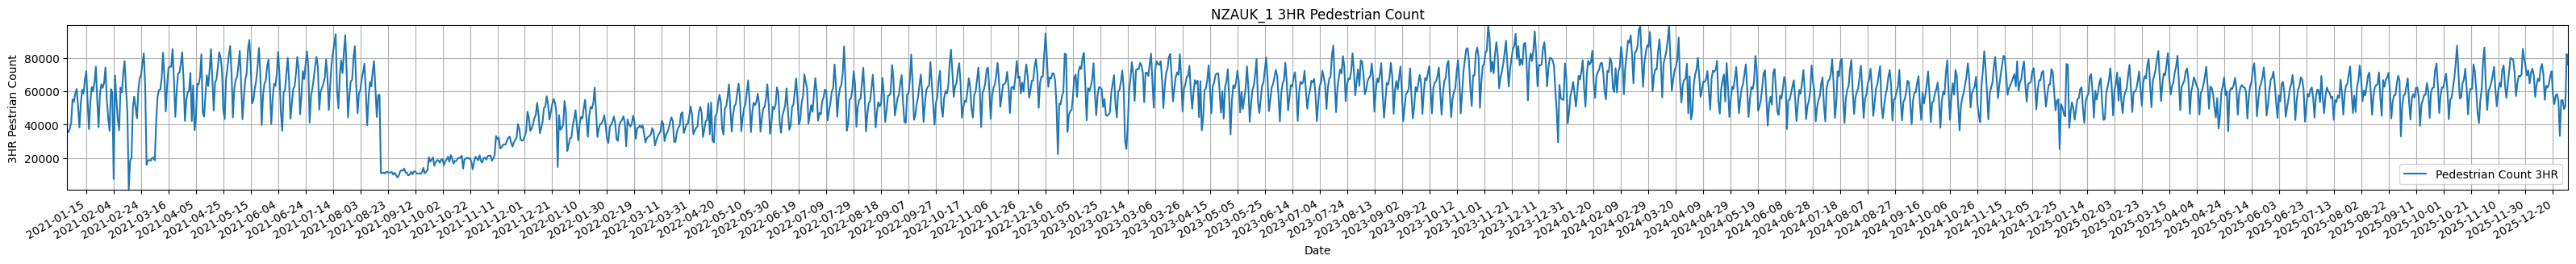

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count
0,New Zealand,Auckland,NZAUK_1,Sky Tower,Observation Tower,Entertainment,-36.8485,174.7633,2021-01-01,36620.0
1,New Zealand,Auckland,NZAUK_1,Sky Tower,Observation Tower,Entertainment,-36.8485,174.7633,2021-01-02,35415.0


Stationary


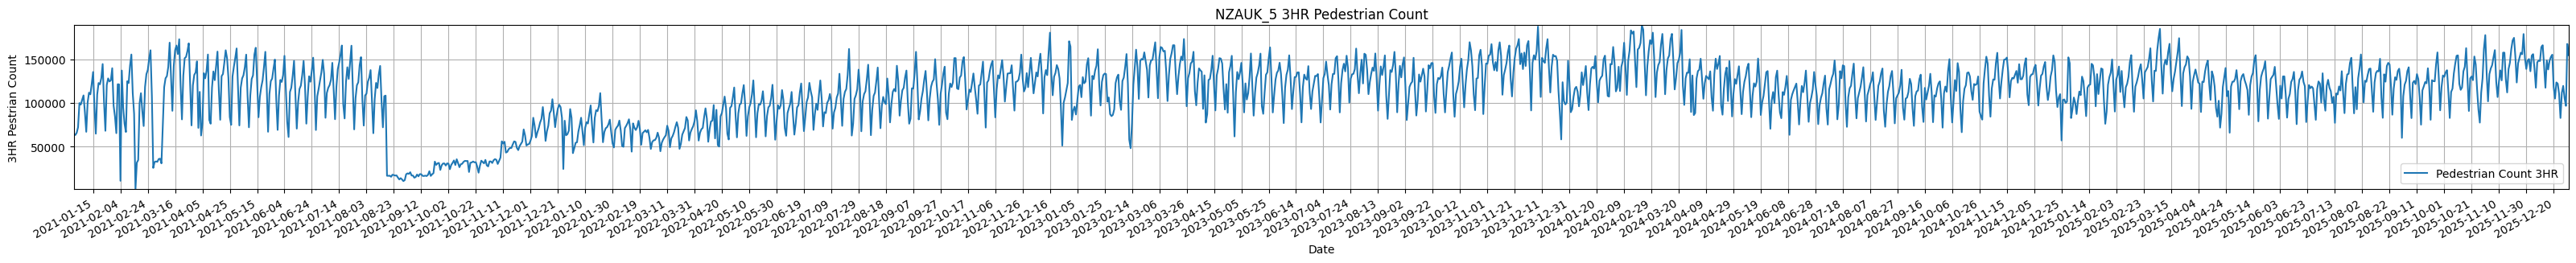

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count
1826,New Zealand,Auckland,NZAUK_5,Britomart,Waterfront,Entertainment,-36.8443,174.767,2021-01-01,65005.0
1827,New Zealand,Auckland,NZAUK_5,Britomart,Waterfront,Entertainment,-36.8443,174.767,2021-01-02,63336.0


Stationary


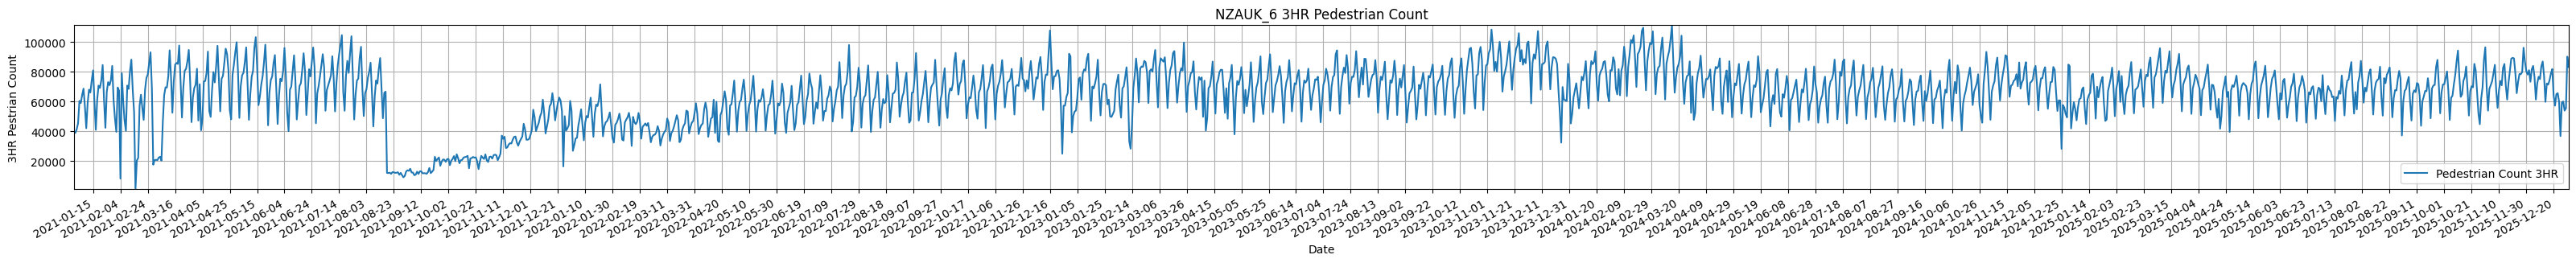

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count
3652,New Zealand,Auckland,NZAUK_6,Mission Bay,Historic Site,Cultural,-36.8475,174.8316,2021-01-01,39893.0
3653,New Zealand,Auckland,NZAUK_6,Mission Bay,Historic Site,Cultural,-36.8475,174.8316,2021-01-02,38848.0


Stationary


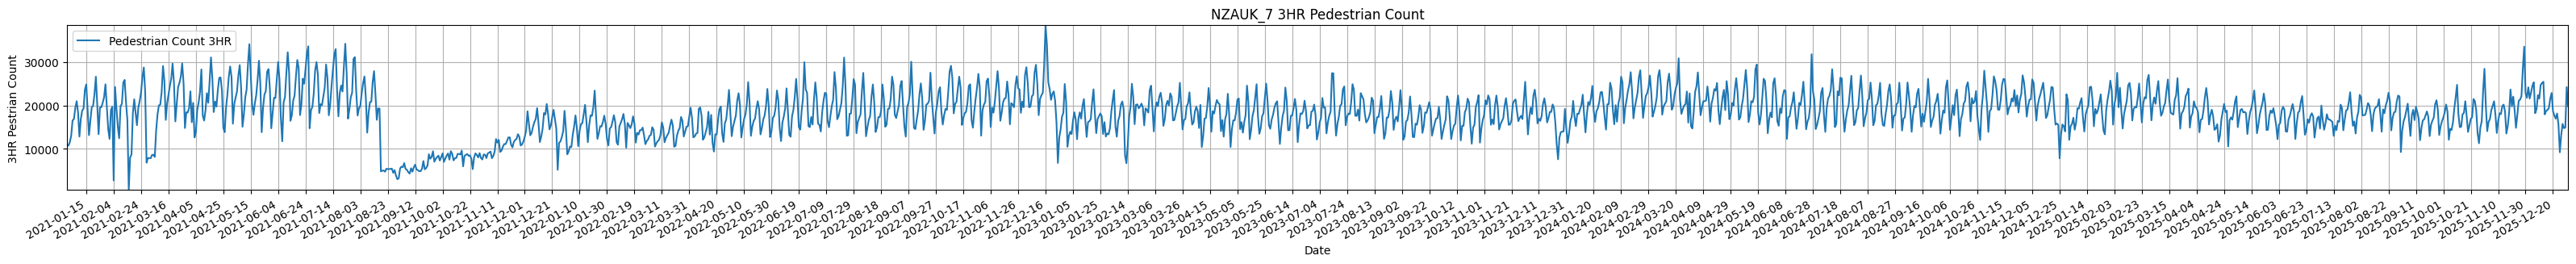

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count
5478,New Zealand,Auckland,NZAUK_7,Kelly Tarlton's Sea Life Aquarium,Aquarium,Entertainment,-36.8531,174.8506,2021-01-01,11026.0
5479,New Zealand,Auckland,NZAUK_7,Kelly Tarlton's Sea Life Aquarium,Aquarium,Entertainment,-36.8531,174.8506,2021-01-02,10723.0


Stationary


In [113]:
for loc in fAuk_d['Location_ID'].unique():
    sub = fAuk_d[fAuk_d['Location_ID'] == loc].sort_values('Date')
    fig,ax = plt.subplots(figsize=(40,3))
    plt.margins(x=0,y=0)
    ax.set_xlabel('Date')
    ax.set_ylabel(f'3HR Pestrian Count')
    ax.plot(sub['Date'], sub['PedsSen_Count'], label='Pedestrian Count 3HR')
    ax.grid(True)
    ax.legend()
    ax.set_title(f'{loc} 3HR Pedestrian Count')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=20))
    fig.autofmt_xdate() # Prevent overcrowding on the x-axis for label 
    plt.show()
    display(sub.head(2))
    adf = adfuller(sub['PedsSen_Count'])
    print('Stationary' if adf[1] < 0.05 else 'Not Stationary')

### Adding additonal features

- Adding Weather

In [132]:
#Need cache for Open Meto from Api Doc
#Setup the Open-Meteo API client with cache and retry on error # <--- this is from Open Meteo Api Docs
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [118]:
def Weather_Requester(lat:float,long:float,stDate:str,edDate:str) -> pd.DataFrame:
  url = "https://archive-api.open-meteo.com/v1/archive"
  params = {
    "latitude": lat,
    "longitude": long,
    "start_date": stDate,
    "end_date": edDate,
    "daily": ["temperature_2m_mean", "wind_gusts_10m_mean", "relative_humidity_2m_mean", "precipitation_sum"],
    "timezone": "auto",
  }
  while 1:
    try:
      responses = openmeteo.weather_api(url, params=params)
      break
    except Exception as e:
      print(f'Openmeto retry {e}',end='',flush=True)
      time.sleep(60)
      print('',end='',flush=True)
      
  #Basically getting the data for the beginning of the dataset set to the end of the dataset per location   
  daily = responses[0].Daily()
  
  daily_data = {"Date": pd.date_range( #Code from Open Meto sandbox, used for building the date columns in %Y-%m-%d %H:%M:%S <- want this format when working in code
          start = pd.to_datetime(daily.Time() + responses[0].UtcOffsetSeconds(), unit = "s", utc = True),
          end =  pd.to_datetime(daily.TimeEnd() + responses[0].UtcOffsetSeconds(), unit = "s", utc = True),
          freq = pd.Timedelta(seconds = daily.Interval()),
          inclusive = "left" 
  )}
  
  daily_data['Weather_Temperature'] = daily.Variables(0).ValuesAsNumpy() #Temp NumpArray
  daily_data['Weather_Wind_Gust'] = daily.Variables(1).ValuesAsNumpy() #Wind Gust NumpArray
  daily_data['Weather_Relative_Humidity'] = daily.Variables(2).ValuesAsNumpy() #Humd NumpArray
  daily_data['Weather_Precipitation'] = daily.Variables(3).ValuesAsNumpy() #Prep NumpArray

  return pd.DataFrame(data = daily_data)

In [119]:
def addWeather(data:pd.DataFrame) -> pd.DataFrame:
    data_cp = data.copy()
    gp = data_cp.groupby(['Latitude','Longitude'],as_index=False)['Date'].agg(['min', 'max'])
    gpC = pd.DataFrame() # We dont want to call Meto each day better to do all per each POI 
    for i,r in gp.iterrows():
        Wth = Weather_Requester(r['Latitude'],r['Longitude'],str(r['min']).split(' ')[0], str(r['max']).split(' ')[0])
        Wth.insert(0, 'Longitude', float(r['Longitude']))
        Wth.insert(0, 'Latitude', float(r['Latitude']))
        Wth['Date'] = Wth['Date'].apply(lambda x: pd.to_datetime(str(str(x).split('+')[0]),format='%Y-%m-%d %H:%M:%S'))
        gpC = pd.concat((gpC,Wth),axis='index',).reset_index(drop=True)
    
    return pd.merge(data_cp,gpC,on=['Latitude','Longitude','Date'],how='outer').dropna(how='any').sort_values(by=['Location_ID','Date']).reset_index(drop=True)

In [120]:
wht_fDub = addWeather(fDub_d)

In [121]:
for loc in wht_fDub['Location_ID'].unique():
    sub = wht_fDub[wht_fDub['Location_ID'] == loc].sort_values('Date')
    display(sub.reset_index(drop=True).loc[1020:1021])

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count,Weather_Temperature,Weather_Wind_Gust,Weather_Relative_Humidity,Weather_Precipitation
1020,Ireland,Dublin,IRDUB_1,Trinity College & Book of Kells,University,Cultural,53.3438,-6.254,2023-10-18,162543.0,13.343251,42.285000,85.359657,6.300001
1021,Ireland,Dublin,IRDUB_1,Trinity College & Book of Kells,University,Cultural,53.3438,-6.254,2023-10-19,166395.0,14.151584,29.610001,91.548920,12.600001


,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count,Weather_Temperature,Weather_Wind_Gust,Weather_Relative_Humidity,Weather_Precipitation
1020,Ireland,Dublin,IRDUB_3,St Stephen's Green,Urban Park,Nature,53.3382,-6.2591,2023-10-18,68103.0,12.356251,46.319996,88.835823,8.0
1021,Ireland,Dublin,IRDUB_3,St Stephen's Green,Urban Park,Nature,53.3382,-6.2591,2023-10-19,66311.0,13.543750,24.449999,92.038208,12.3


,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count,Weather_Temperature,Weather_Wind_Gust,Weather_Relative_Humidity,Weather_Precipitation
1020,Ireland,Dublin,IRDUB_4,Temple Bar District,Entertainment District,Entertainment,53.3455,-6.2643,2023-10-18,275685.0,13.077750,46.319996,88.894745,8.0
1021,Ireland,Dublin,IRDUB_4,Temple Bar District,Entertainment District,Entertainment,53.3455,-6.2643,2023-10-19,284034.0,14.265251,24.449999,92.079491,12.3


,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count,Weather_Temperature,Weather_Wind_Gust,Weather_Relative_Humidity,Weather_Precipitation
1020,Ireland,Dublin,IRDUB_5,Dublin Castle,Historic Site,Cultural,53.3429,-6.2674,2023-10-18,35938.0,12.356251,46.319996,88.835823,8.0
1021,Ireland,Dublin,IRDUB_5,Dublin Castle,Historic Site,Cultural,53.3429,-6.2674,2023-10-19,41577.0,13.543750,24.449999,92.038208,12.3


,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count,Weather_Temperature,Weather_Wind_Gust,Weather_Relative_Humidity,Weather_Precipitation
1020,Ireland,Dublin,IRDUB_8,EPIC The Irish Emigration Museum,Museum,Cultural,53.3471,-6.2416,2023-10-18,461734.0,13.356252,42.285000,85.361015,6.300001
1021,Ireland,Dublin,IRDUB_8,EPIC The Irish Emigration Museum,Museum,Cultural,53.3471,-6.2416,2023-10-19,486348.0,14.164584,29.610001,91.549736,12.600001


In [123]:
wht_fAuk = addWeather(fAuk_d)

In [124]:
for loc in wht_fAuk['Location_ID'].unique():
    sub = wht_fAuk[wht_fAuk['Location_ID'] == loc].sort_values('Date')
    display(sub.reset_index(drop=True).head(2))

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count,Weather_Temperature,Weather_Wind_Gust,Weather_Relative_Humidity,Weather_Precipitation
0,New Zealand,Auckland,NZAUK_1,Sky Tower,Observation Tower,Entertainment,-36.8485,174.7633,2021-01-01,36620.0,18.858334,18.749998,78.877708,0.700000
1,New Zealand,Auckland,NZAUK_1,Sky Tower,Observation Tower,Entertainment,-36.8485,174.7633,2021-01-02,35415.0,18.966665,19.724998,86.536705,15.800002


,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count,Weather_Temperature,Weather_Wind_Gust,Weather_Relative_Humidity,Weather_Precipitation
0,New Zealand,Auckland,NZAUK_5,Britomart,Waterfront,Entertainment,-36.8443,174.767,2021-01-01,65005.0,18.858334,18.749998,78.877708,0.700000
1,New Zealand,Auckland,NZAUK_5,Britomart,Waterfront,Entertainment,-36.8443,174.767,2021-01-02,63336.0,18.966665,19.724998,86.536705,15.800002


,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count,Weather_Temperature,Weather_Wind_Gust,Weather_Relative_Humidity,Weather_Precipitation
0,New Zealand,Auckland,NZAUK_6,Mission Bay,Historic Site,Cultural,-36.8475,174.8316,2021-01-01,39893.0,18.858334,18.749998,78.877708,0.700000
1,New Zealand,Auckland,NZAUK_6,Mission Bay,Historic Site,Cultural,-36.8475,174.8316,2021-01-02,38848.0,18.966665,19.724998,86.536705,15.800002


,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count,Weather_Temperature,Weather_Wind_Gust,Weather_Relative_Humidity,Weather_Precipitation
0,New Zealand,Auckland,NZAUK_7,Kelly Tarlton's Sea Life Aquarium,Aquarium,Entertainment,-36.8531,174.8506,2021-01-01,11026.0,18.773834,18.749998,78.865990,0.700000
1,New Zealand,Auckland,NZAUK_7,Kelly Tarlton's Sea Life Aquarium,Aquarium,Entertainment,-36.8531,174.8506,2021-01-02,10723.0,18.882166,19.724998,86.528633,15.800002


In [125]:
def add_features(ForgerData:pd.DataFrame,CCode:str)->pd.DataFrame:
    cp_ForgerData = ForgerData.copy().reset_index(drop=True)
    #Adding Holiday Column
    cp_ForgerData.insert(14,'Is_Holiday',0)
    cp_ForgerData['Is_Holiday'] = cp_ForgerData['Date'].apply(lambda x: 1 if hl.country_holidays(country=CCode).get(x) != None else 0)   
    return cp_ForgerData

In [126]:
add_features_Dub = add_features(wht_fDub,'IE')

In [127]:
add_features_Auk = add_features(wht_fAuk,'NZ')

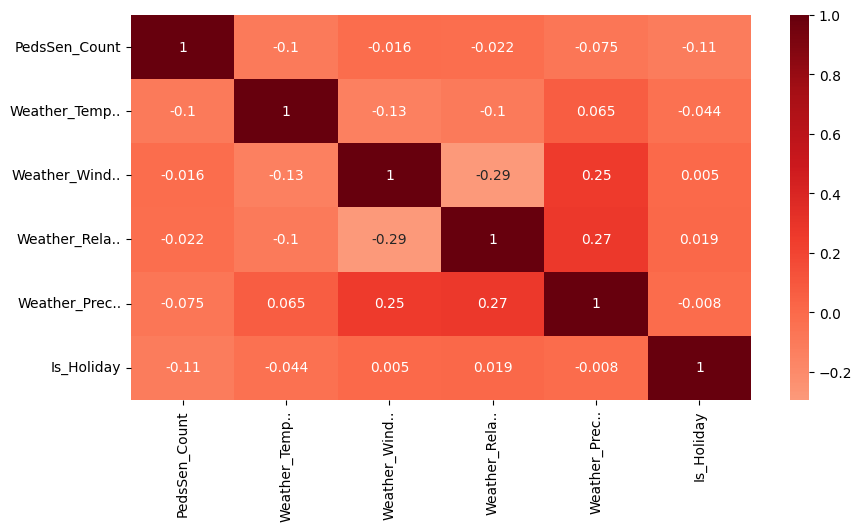

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count,Weather_Temperature,Weather_Wind_Gust,Weather_Relative_Humidity,Weather_Precipitation,Is_Holiday
0,Ireland,Dublin,IRDUB_1,Trinity College & Book of Kells,University,Cultural,53.3438,-6.254,2021-01-01,33648.0,3.6995,30.809999,87.589973,1.2,1
1,Ireland,Dublin,IRDUB_1,Trinity College & Book of Kells,University,Cultural,53.3438,-6.254,2021-01-02,38277.0,2.4745,31.094999,86.966187,0.5,0


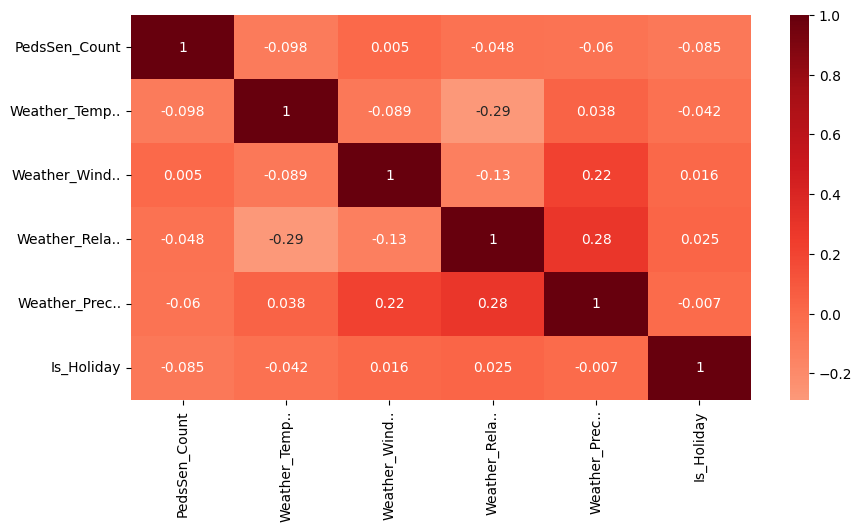

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count,Weather_Temperature,Weather_Wind_Gust,Weather_Relative_Humidity,Weather_Precipitation,Is_Holiday
1826,Ireland,Dublin,IRDUB_3,St Stephen's Green,Urban Park,Nature,53.3382,-6.2591,2021-01-01,12914.0,2.25625,24.119997,92.917198,1.3,1
1827,Ireland,Dublin,IRDUB_3,St Stephen's Green,Urban Park,Nature,53.3382,-6.2591,2021-01-02,14915.0,0.95000,25.694998,92.585243,0.4,0


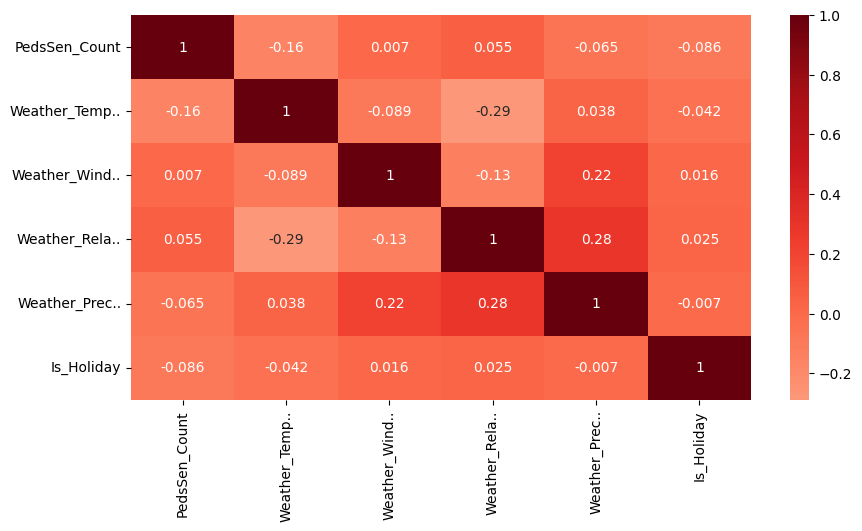

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count,Weather_Temperature,Weather_Wind_Gust,Weather_Relative_Humidity,Weather_Precipitation,Is_Holiday
3652,Ireland,Dublin,IRDUB_4,Temple Bar District,Entertainment District,Entertainment,53.3455,-6.2643,2021-01-01,43501.0,2.97775,24.119997,92.957130,1.3,1
3653,Ireland,Dublin,IRDUB_4,Temple Bar District,Entertainment District,Entertainment,53.3455,-6.2643,2021-01-02,60374.0,1.67150,25.694998,92.627312,0.4,0


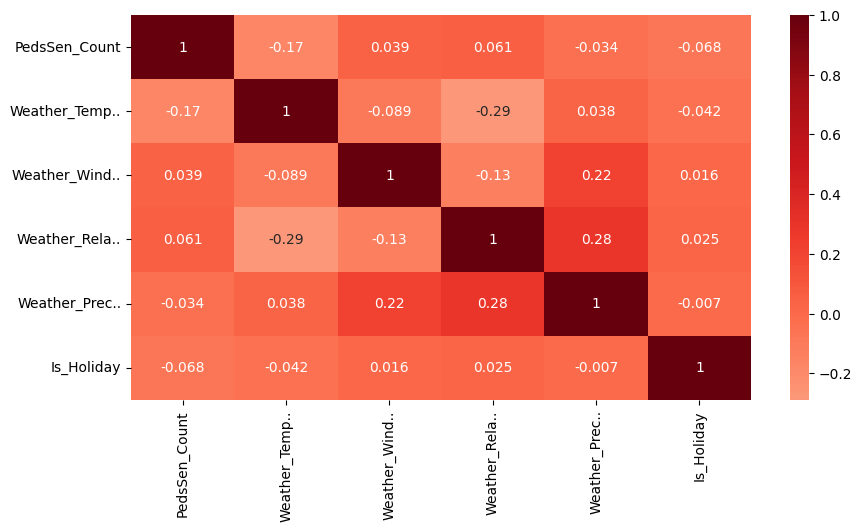

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count,Weather_Temperature,Weather_Wind_Gust,Weather_Relative_Humidity,Weather_Precipitation,Is_Holiday
5478,Ireland,Dublin,IRDUB_5,Dublin Castle,Historic Site,Cultural,53.3429,-6.2674,2021-01-01,4843.0,2.25625,24.119997,92.917198,1.3,1
5479,Ireland,Dublin,IRDUB_5,Dublin Castle,Historic Site,Cultural,53.3429,-6.2674,2021-01-02,5331.0,0.95000,25.694998,92.585243,0.4,0


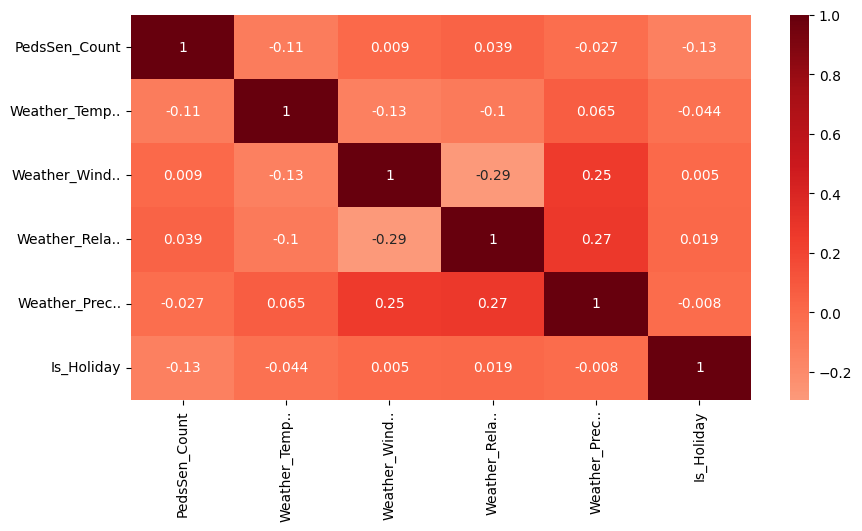

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count,Weather_Temperature,Weather_Wind_Gust,Weather_Relative_Humidity,Weather_Precipitation,Is_Holiday
7304,Ireland,Dublin,IRDUB_8,EPIC The Irish Emigration Museum,Museum,Cultural,53.3471,-6.2416,2021-01-01,58105.0,3.7125,30.809999,87.591194,1.2,1
7305,Ireland,Dublin,IRDUB_8,EPIC The Irish Emigration Museum,Museum,Cultural,53.3471,-6.2416,2021-01-02,78957.0,2.4875,31.094999,86.967468,0.5,0


In [128]:
for loc in add_features_Dub['Location_ID'].unique():
    sub = add_features_Dub[add_features_Dub['Location_ID'] == loc].sort_values('Date')
    # sub = sub.drop(columns=GB1_cols_to_not_use)
    plt.figure(figsize=(10, 5)) 
    df_col_idnx = 9 
    truncated_cols = [ name[:12] + '..' if len(name) > 15 else name for name in sub.columns[df_col_idnx:] ]
    sea.heatmap(sub[sub.columns[df_col_idnx:]].corr().round(3), 
                xticklabels=truncated_cols, yticklabels=truncated_cols, annot=True, 
                cmap='Reds', center=0, cbar=True)
    plt.show()
    display(sub.head(2))

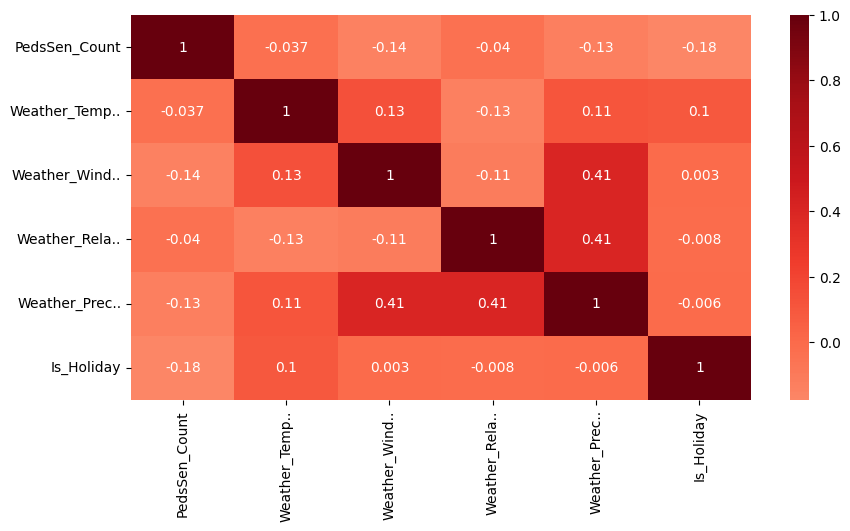

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count,Weather_Temperature,Weather_Wind_Gust,Weather_Relative_Humidity,Weather_Precipitation,Is_Holiday
0,New Zealand,Auckland,NZAUK_1,Sky Tower,Observation Tower,Entertainment,-36.8485,174.7633,2021-01-01,36620.0,18.858334,18.749998,78.877708,0.700000,1
1,New Zealand,Auckland,NZAUK_1,Sky Tower,Observation Tower,Entertainment,-36.8485,174.7633,2021-01-02,35415.0,18.966665,19.724998,86.536705,15.800002,1


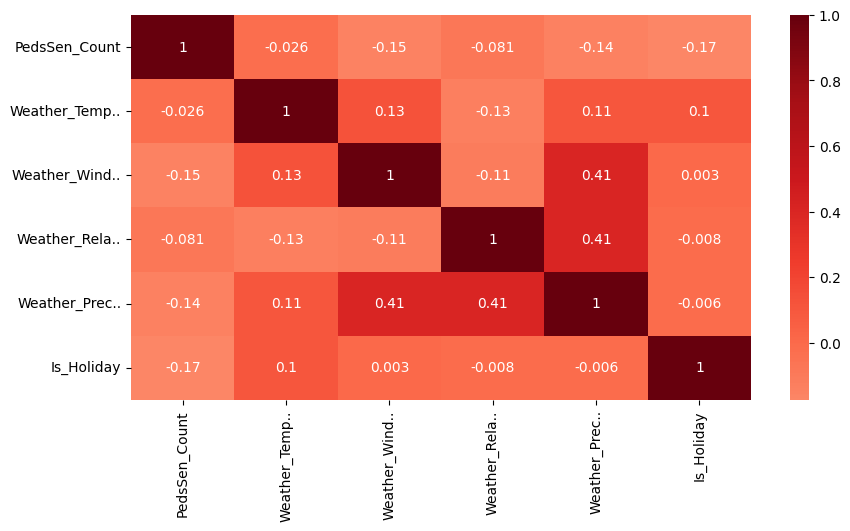

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count,Weather_Temperature,Weather_Wind_Gust,Weather_Relative_Humidity,Weather_Precipitation,Is_Holiday
1826,New Zealand,Auckland,NZAUK_5,Britomart,Waterfront,Entertainment,-36.8443,174.767,2021-01-01,65005.0,18.858334,18.749998,78.877708,0.700000,1
1827,New Zealand,Auckland,NZAUK_5,Britomart,Waterfront,Entertainment,-36.8443,174.767,2021-01-02,63336.0,18.966665,19.724998,86.536705,15.800002,1


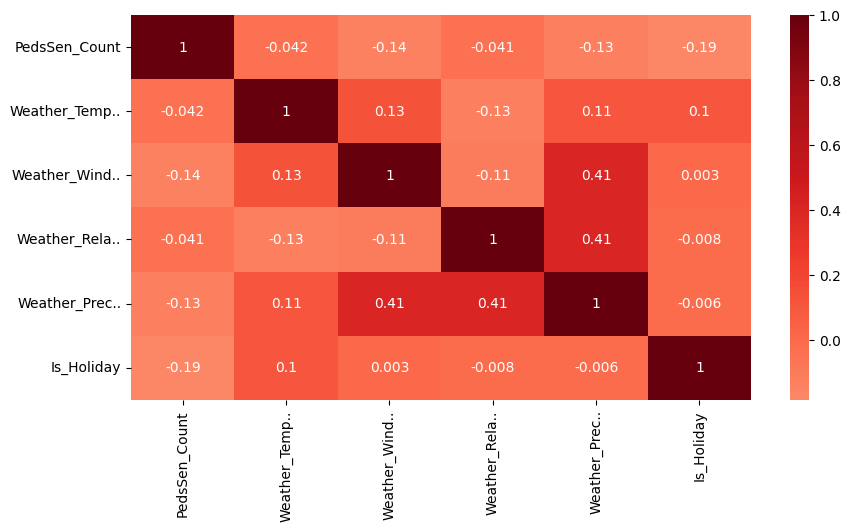

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count,Weather_Temperature,Weather_Wind_Gust,Weather_Relative_Humidity,Weather_Precipitation,Is_Holiday
3652,New Zealand,Auckland,NZAUK_6,Mission Bay,Historic Site,Cultural,-36.8475,174.8316,2021-01-01,39893.0,18.858334,18.749998,78.877708,0.700000,1
3653,New Zealand,Auckland,NZAUK_6,Mission Bay,Historic Site,Cultural,-36.8475,174.8316,2021-01-02,38848.0,18.966665,19.724998,86.536705,15.800002,1


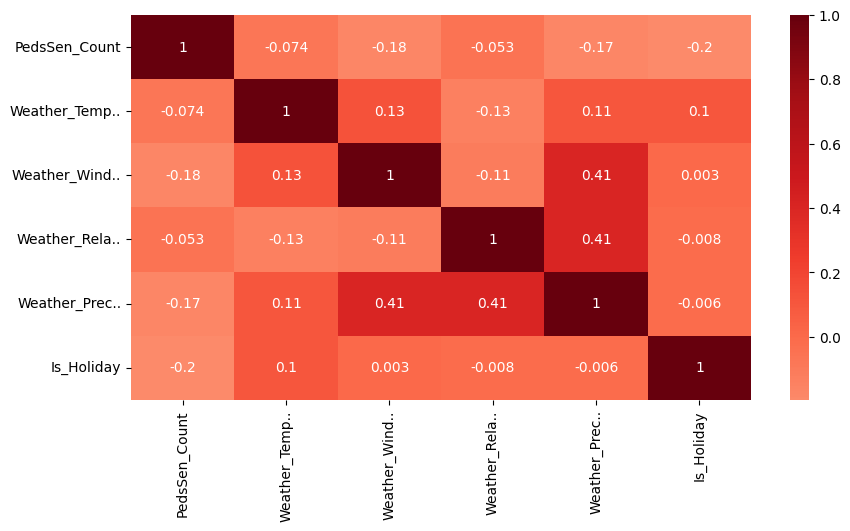

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,PedsSen_Count,Weather_Temperature,Weather_Wind_Gust,Weather_Relative_Humidity,Weather_Precipitation,Is_Holiday
5478,New Zealand,Auckland,NZAUK_7,Kelly Tarlton's Sea Life Aquarium,Aquarium,Entertainment,-36.8531,174.8506,2021-01-01,11026.0,18.773834,18.749998,78.865990,0.700000,1
5479,New Zealand,Auckland,NZAUK_7,Kelly Tarlton's Sea Life Aquarium,Aquarium,Entertainment,-36.8531,174.8506,2021-01-02,10723.0,18.882166,19.724998,86.528633,15.800002,1


In [129]:
for loc in add_features_Auk['Location_ID'].unique():
    sub = add_features_Auk[add_features_Auk['Location_ID'] == loc].sort_values('Date')
    # sub = sub.drop(columns=GB1_cols_to_not_use)
    plt.figure(figsize=(10, 5)) 
    df_col_idnx = 9 
    truncated_cols = [ name[:12] + '..' if len(name) > 15 else name for name in sub.columns[df_col_idnx:] ]
    sea.heatmap(sub[sub.columns[df_col_idnx:]].corr().round(3), 
                xticklabels=truncated_cols, yticklabels=truncated_cols, annot=True, 
                cmap='Reds', center=0, cbar=True)
    plt.show()
    display(sub.head(2))

### Output final data sets to final folder

In [130]:
add_features_Dub.to_csv(f"{OUTDIR}/Dublin_Pedestrian_daily.csv", index=False)
add_features_Auk.to_csv(f"{OUTDIR}/Auckland_Pedestrian_daily.csv", index=False)